In [46]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A
import albumentations.pytorch
import cv2
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from cutmix.cutmix import CutMix
# from cutmix.utils import CutMixCrossEntropyLoss
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize
from tqdm import tqdm

import wandb

config={
    "lr": 1e-4,
    "architecture": "efficientnet-b4",
    "dataset": "vanilla",
    "augmentation" : "cutmix",
    "loss" : "weighted",
    "gamma" : 0.99,
    "batch_size" : 50,
    "epochs" : 10,
}
config['model'] = '_'.join([config['architecture'], config['dataset'], config['augmentation'], config['loss'], str(config['batch_size']), str(config['lr']), str(config['gamma'])])
wandb.init(project="MaskClassification", name=config['model'], config=config)



Train Loss,0.02939
_runtime,8626
_timestamp,1629967942
_step,41
Validation Loss,0.07363
Validation Total Accuracy,98.18519
Validation F1,0.97863


Train Loss,█▇▆▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆█
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
Validation Loss,█▇▇▇▆▅▅▅▅▄▃▂▂▂▂▂▁▁▁▁
Validation Total Accuracy,▁▂▄▄▅▅▅▆▆▆▇▇▇▇▇▇████
Validation F1,▁▂▃▄▅▅▅▆▆▇▇▇▇▇▇▇████



CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



In [47]:
print('CUDA GPU available : {}'.format(torch.cuda.is_available()))
try:
    print('{} GPU(s) is(are) allocated'.format(torch.cuda.device_count()))
except:
    print('GPUs are not allocated. Current runtime is on CPU.')
device = torch.device("cuda")
CUDA_LAUNCH_BLOCKING=1

CUDA GPU available : True
1 GPU(s) is(are) allocated


In [48]:
# 테스트 데이터셋 폴더 경로를 지정해주세요.
test_dir = '/opt/ml/input/data/eval'
train_dir = '/opt/ml/input/data/train'

labels_to_class = {}
it = [(m, g, a) for m in [0,1,2] for g in [0, 1] for a in [0, 1, 2]]
for i, (m, g, a) in enumerate(it):
    labels_to_class[(m, g, a)] = i

## Dataset

In [49]:
class TrainDataset(Dataset):
    def __init__(self, train_dir, is_Train=True, transform=None):
        super().__init__()
        
        csv_path = os.path.join(train_dir, 'train.csv')
        csv = pd.read_csv(csv_path)
        self.image_dir = os.path.join(train_dir, 'images')
        self.transform = transform
        self.image_path = []
        path = csv['path']
        
        for p in path:
            images = [os.path.join(*[self.image_dir, p, image]) for image in os.listdir(os.path.join(self.image_dir, p)) if not image[:1] == '.']
            for image in images:
                self.image_path.append(image)
                
        self.comb_dic = {}
        comb = [(m, g, a) for m in ['m', 'i', 'n'] for g in ['male', 'female'] for a in [0, 1, 2]]
        for i, (m, g, a) in enumerate(comb):
            self.comb_dic[(m, g, a)] = i
            
    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):
        image_name = self.image_path[idx]
        image = cv2.imread(image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        features = image_name.split('/')[-2:]
        
        mask = features[1][0]
        age = int(features[0].split('_')[-1])
        gender = features[0].split('_')[1]
        
        if age >= 58: # 원래 60
            age = 2
        elif age >= 30: # 원래 30
            age = 1
        else:
            age = 0        
        
        target = self.comb_dic[(mask, gender, age)]
        
        if self.transform:
            image = self.transform(image=image)['image']
        
        return image, target

class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = cv2.imread(self.img_paths[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        return image

    def __len__(self):
        return len(self.img_paths)

In [51]:
from torch.utils.data.sampler import SubsetRandomSampler
from copy import copy
# from torch.utils.data.dataset import random_split

tfms = A.Compose([
        A.augmentations.crops.transforms.CenterCrop(400, 360, p=1.0),
        A.augmentations.geometric.resize.Resize(224, 224, interpolation=1, p=1),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.6),
        A.RandomBrightnessContrast(brightness_limit=0.1, p=0.6),
        A.GaussNoise(p=0.5),
        A.transforms.Normalize(mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246), max_pixel_value=255.0, p=1.0),
        A.pytorch.transforms.ToTensorV2(),
    ])
tfms_test = A.Compose([
        A.augmentations.crops.transforms.CenterCrop(400, 360, p=1.0),
        A.augmentations.geometric.resize.Resize(224, 224, interpolation=1, p=1),
        A.transforms.Normalize(mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246), max_pixel_value=255.0, p=1.0),
        A.pytorch.transforms.ToTensorV2(),
    ])
val_idx = []
person_idx = list(range(2700))

np.random.seed(211)
np.random.shuffle(person_idx)

n_val_person = int(2700 * 0.2)
val_person_idx = person_idx[:n_val_person]
train_indices = []
val_indices = []
for i in range(2700*7):
    if i // 15 not in val_person_idx:
        train_indices.append(i)
    else:
        val_indices.append(i)

# print(train_indices)
# print(val_indices)
# train_sampler = SubsetRandomSampler(train_indices)
# valid_sampler = SubsetRandomSampler(val_indices)
np.random.shuffle(train_indices)
np.random.shuffle(val_indices)

dataset = TrainDataset(train_dir, transform=tfms)
val_dataset = copy(dataset)
train_dataset = CutMix(dataset, num_class=18, beta=1.0, prob=0.5, num_mix=2)
# print(len(dataset))
# plt.imshow(np.array(train_dataset[312][0]['image'].permute(1,2,0)))

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], num_workers=4, pin_memory=True, sampler=train_indices)
val_loader = DataLoader(val_dataset, num_workers=4, batch_size=config['batch_size'], pin_memory=True, sampler=val_indices)

In [52]:
# plt.imshow(np.array(train_dataset[312][0]['image'].permute(1,2,0)))
# dataset[0]

## Model

In [53]:
from efficientnet_pytorch import EfficientNet
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.backbone = EfficientNet.from_pretrained(config['architecture'], num_classes=18)
        self.best_f1 = 0
        self.best_valid = 999999999
    def forward(self, x):
        return self.backbone(x)
        
model = Net().to(device)

Loaded pretrained weights for efficientnet-b4


In [54]:
import torch.optim as optim 

class_distribution = torch.tensor([2745, 2050, 415, 3660, 4085, 545, 
                      555, 314, 179, 726, 669, 257, 
                      555, 314, 179, 726, 669, 257])
normedWeights = [1 - (x / sum(class_distribution)) for x in class_distribution]
loss_distribution = class_distribution / class_distribution.sum()
# print(class_distribution)
loss_distribution = 1.0 / loss_distribution
loss_distribution = (loss_distribution / loss_distribution.sum()*10).to(device)
print(loss_distribution)

class CutMixCrossEntropyLoss(nn.Module):
    def __init__(self, weight):
        super().__init__()
        self.weight = weight

    def forward(self, inputs, targets):
        if len(targets.size()) == 1:
            targets = torch.nn.functional.one_hot(targets, num_classes=input.size(-1))
            targets = targets.float().cuda()
        logsoftmax = torch.nn.LogSoftmax(dim=1)

        return torch.mean(torch.sum(-targets * logsoftmax(inputs) * self.weight, dim=1))

# origin_criterion = CutMixCrossEntropyLoss(True)
val_criterion = nn.CrossEntropyLoss(weight=loss_distribution)
cutmix_criterion = CutMixCrossEntropyLoss(weight=loss_distribution)

optimizer = optim.Adam(model.parameters(), lr=config['lr'])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=config['gamma'], verbose=True)

tensor([0.0904, 0.1211, 0.5981, 0.0678, 0.0608, 0.4554, 0.4472, 0.7905, 1.3867,
        0.3419, 0.3710, 0.9658, 0.4472, 0.7905, 1.3867, 0.3419, 0.3710, 0.9658],
       device='cuda:0')
Adjusting learning rate of group 0 to 1.0000e-04.


In [55]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

def check():
    model.eval()
    val_loss = 0.0
    counter = 0
    y_true = []
    y_predicted = []
    
    with torch.no_grad():
        prog_bar = tqdm(enumerate(val_loader), total=int(len(val_indices)/val_loader.batch_size))
        for i, (x, y) in prog_bar:
            counter += 1
            y_true += y.tolist()
            
            x = x.to(device=device)
            y = y.to(device=device)
    
            scores = model(x)
            _, predictions = scores.max(1)
            y_predicted += predictions.tolist()
            
            
            loss = val_criterion(scores, y)
            
            val_loss += loss.item()
#     print(y_true, y_predicted)
    cm = confusion_matrix(y_true, y_predicted)
    F1 = []
    for c in range(18):
        precision = cm[c][c] / np.sum(cm, axis=0)[c]
        recall = cm[c][c] / np.sum(cm, axis=1)[c]
        F1.append(2 * precision * recall / (precision + recall))
    macro_F1 = np.mean(F1)
    
    print("< VALIDATION >")
    print("*"*73)
    print("Validation Loss :", val_loss/counter)
    print("-"*73)
    print("Total Accuracy")
    print(accuracy_score(y_true, y_predicted) * 100, "%")
    print("-"*73)
    print("Confusion Matrix")
    for row in cm:
        for c in row:
            print(str(c).ljust(4), end='')
        print()
    print("-"*73)
    print("Validation F1 score :" , macro_F1)
    for c, f in enumerate(F1):
        print("Class", c, ":", f)
        
    if model.best_f1 < macro_F1:
        model.best_f1 = macro_F1
#     if model.best_valid > val_loss/counter:
#         model.best_valid = val_loss/counter
        torch.save(model.state_dict(), '/opt/ml/weights/{}/{:.4f}.pt'.format(config['model'], model.best_f1))
    print("model saved!")
    print("*"*73)
    print()
    wandb.log({
        "Validation Loss" : val_loss/counter, 
        "Validation Total Accuracy" :accuracy_score(y_true, y_predicted) * 100, 
        "Validation F1" : macro_F1,
    })
        
    model.train()

In [56]:

folder = '/opt/ml/weights/{}'.format(config['model'])
if not os.path.exists(folder):
    os.mkdir(folder)

for epoch in range(config['epochs']):
    print("Epoch :", epoch + 1)
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    total = 0
    total_it = int(len(train_indices)/train_loader.batch_size)
    prog_bar = tqdm(enumerate(train_loader), total=total_it)
    for i, (inputs, labels) in prog_bar:
        
        counter += 1
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        total += labels.size(0)
    
        outputs = model(inputs)
        loss = cutmix_criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs.data, 1)
#         train_running_correct += (preds == labels).sum().item()
        
        train_running_loss += loss.item()
        
        if i == total_it//2 or i == total_it-1:
            train_loss = train_running_loss / counter
#             train_accuracy = 100. * train_running_correct / total
            
            print("Train Loss :", train_loss)
#             print("Train Accuracy :", train_accuracy)
            wandb.log({"Train Loss" : train_loss})
            check()
    scheduler.step()
    train_running_loss = 0.0
    train_running_correct = 0
print("Finish")

Epoch : 1


 50%|████▉     | 150/301 [00:52<00:52,  2.89it/s]

Train Loss : 0.620616032390405



 99%|█████████▊| 75/76 [00:08<00:00,  9.97it/s]
77it [00:08,  8.66it/s]                        


< VALIDATION >
*************************************************************************
Validation Loss : 1.0682040189767812
-------------------------------------------------------------------------
Total Accuracy
62.34375 %
-------------------------------------------------------------------------
Confusion Matrix
560 1   0   7   0   0   10  0   0   0   0   0   0   0   0   0   0   0   
59  38  188 1   1   22  10  4   1   0   1   0   0   0   0   0   0   0   
6   9   168 0   0   7   0   1   3   0   0   0   0   0   0   0   0   0   
75  0   0   615 0   4   1   0   0   55  0   0   1   0   0   6   0   0   
69  10  9   78  13  434 5   1   0   4   3   0   0   0   0   0   0   0   
3   0   0   4   1   257 0   0   0   0   0   3   0   0   0   0   0   0   
0   0   0   0   0   0   110 0   0   2   0   0   0   0   0   0   0   0   
1   0   6   0   0   1   11  33  9   0   7   1   0   0   1   0   0   0   
0   0   2   0   0   1   1   14  19  0   2   0   0   0   0   0   0   0   
0   0   0   2   0   0   4 

 50%|█████     | 151/301 [01:02<07:52,  3.15s/it]

model saved!
*************************************************************************



100%|█████████▉| 300/301 [01:53<00:00,  2.89it/s]

Train Loss : 0.5266420289725561



 99%|█████████▊| 75/76 [00:08<00:00, 10.17it/s]
77it [00:08,  8.77it/s]                        


< VALIDATION >
*************************************************************************
Validation Loss : 0.7226851381264724
-------------------------------------------------------------------------
Total Accuracy
70.02604166666667 %
-------------------------------------------------------------------------
Confusion Matrix
555 2   0   11  1   1   8   0   0   0   0   0   0   0   0   0   0   0   
28  22  244 1   13  12  1   3   1   0   0   0   0   0   0   0   0   0   
3   1   182 0   0   5   0   0   3   0   0   0   0   0   0   0   0   0   
15  0   3   704 11  2   0   0   0   21  0   0   0   0   0   1   0   0   
6   4   9   83  113 399 0   0   0   1   5   6   0   0   0   0   0   0   
0   0   0   0   8   255 0   0   0   0   0   4   0   0   0   0   0   1   
0   0   0   0   0   0   104 6   0   2   0   0   0   0   0   0   0   0   
0   0   2   0   0   0   1   36  28  1   2   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   8   30  0   1   0   0   0   0   0   0   0   
0   0   0   1   0

100%|██████████| 301/301 [02:03<00:00,  3.11s/it]

model saved!
*************************************************************************



302it [02:03,  2.44it/s]                         

Adjusting learning rate of group 0 to 9.9000e-05.
Epoch : 2



 50%|████▉     | 150/301 [00:52<00:54,  2.77it/s]

Train Loss : 0.3820164776006282



 99%|█████████▊| 75/76 [00:08<00:00,  9.01it/s]
77it [00:08,  8.74it/s]                        


< VALIDATION >
*************************************************************************
Validation Loss : 0.6174918405421368
-------------------------------------------------------------------------
Total Accuracy
75.703125 %
-------------------------------------------------------------------------
Confusion Matrix
543 14  0   7   1   3   10  0   0   0   0   0   0   0   0   0   0   0   
9   213 87  0   7   4   0   3   2   0   0   0   0   0   0   0   0   0   
0   39  148 0   0   2   0   1   4   0   0   0   0   0   0   0   0   0   
13  0   0   719 6   2   1   0   0   14  0   0   0   0   0   2   0   0   
1   12  1   71  174 360 1   0   0   0   4   2   0   0   0   0   0   0   
0   2   0   0   10  254 0   0   0   0   1   1   0   0   0   0   0   0   
0   0   0   0   0   0   108 3   0   1   0   0   0   0   0   0   0   0   
0   0   1   0   0   0   5   47  15  0   2   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   8   30  0   1   0   0   0   0   0   0   0   
0   0   0   1   0   0   1

 50%|█████     | 151/301 [01:02<07:52,  3.15s/it]

model saved!
*************************************************************************



100%|█████████▉| 300/301 [01:54<00:00,  2.91it/s]

Train Loss : 0.37306443643926385



 99%|█████████▊| 75/76 [00:08<00:00,  8.56it/s]
77it [00:08,  8.74it/s]                        
100%|██████████| 301/301 [02:03<00:00,  3.06s/it]

< VALIDATION >
*************************************************************************
Validation Loss : 0.5797939939158303
-------------------------------------------------------------------------
Total Accuracy
76.92708333333333 %
-------------------------------------------------------------------------
Confusion Matrix
555 8   0   8   1   0   6   0   0   0   0   0   0   0   0   0   0   0   
11  135 157 0   14  7   0   1   0   0   0   0   0   0   0   0   0   0   
0   23  167 0   0   2   0   0   2   0   0   0   0   0   0   0   0   0   
11  0   0   714 17  1   0   0   0   14  0   0   0   0   0   0   0   0   
2   5   0   60  262 291 0   0   0   0   6   0   0   0   0   0   0   0   
0   0   0   0   12  255 0   0   0   0   0   1   0   0   0   0   0   0   
0   0   0   0   0   0   101 9   0   1   1   0   0   0   0   0   0   0   
0   0   1   0   0   0   1   37  26  0   5   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   9   29  0   1   0   0   0   0   0   0   0   
0   0   0   1   0

302it [02:03,  2.44it/s]                         

Adjusting learning rate of group 0 to 9.8010e-05.
Epoch : 3



 50%|████▉     | 150/301 [00:52<00:52,  2.89it/s]

Train Loss : 0.34310779725478974



 99%|█████████▊| 75/76 [00:08<00:00,  8.92it/s]
77it [00:08,  8.67it/s]                        


< VALIDATION >
*************************************************************************
Validation Loss : 0.5883216737926781
-------------------------------------------------------------------------
Total Accuracy
81.640625 %
-------------------------------------------------------------------------
Confusion Matrix
542 18  0   5   5   1   7   0   0   0   0   0   0   0   0   0   0   0   
8   247 53  1   13  3   0   0   0   0   0   0   0   0   0   0   0   0   
0   62  131 0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   
7   0   0   728 12  0   0   0   0   10  0   0   0   0   0   0   0   0   
2   9   0   67  353 192 0   0   0   0   2   1   0   0   0   0   0   0   
0   0   0   0   35  233 0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   105 6   0   1   0   0   0   0   0   0   0   0   
0   1   0   0   0   0   2   54  9   0   4   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   16  22  0   1   0   0   0   0   0   0   0   
0   0   0   1   0   0   1

 50%|█████     | 151/301 [01:02<07:53,  3.15s/it]

model saved!
*************************************************************************



100%|█████████▉| 300/301 [01:54<00:00,  2.90it/s]

Train Loss : 0.337917893481413



 99%|█████████▊| 75/76 [00:08<00:00,  9.34it/s]
77it [00:09,  8.52it/s]                        
100%|██████████| 301/301 [02:03<00:00,  3.13s/it]

< VALIDATION >
*************************************************************************
Validation Loss : 0.5201274083032237
-------------------------------------------------------------------------
Total Accuracy
78.64583333333334 %
-------------------------------------------------------------------------
Confusion Matrix
555 12  0   7   2   1   1   0   0   0   0   0   0   0   0   0   0   0   
6   127 182 0   6   4   0   0   0   0   0   0   0   0   0   0   0   0   
0   9   184 0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   
9   1   0   717 13  1   0   0   0   15  0   0   0   0   0   1   0   0   
1   7   3   53  296 264 0   0   0   0   2   0   0   0   0   0   0   0   
0   0   0   0   18  249 0   0   0   0   0   1   0   0   0   0   0   0   
0   0   0   0   0   0   103 6   0   2   1   0   0   0   0   0   0   0   
0   1   1   0   0   0   1   35  30  0   2   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   6   32  0   1   0   0   0   0   0   0   0   
0   0   0   1   0

302it [02:04,  2.44it/s]                         

Adjusting learning rate of group 0 to 9.7030e-05.
Epoch : 4



 50%|████▉     | 150/301 [00:53<00:52,  2.87it/s]

Train Loss : 0.31082039262285294



 99%|█████████▊| 75/76 [00:08<00:00, 10.30it/s]
77it [00:08,  8.72it/s]                        


< VALIDATION >
*************************************************************************
Validation Loss : 0.5984934452292207
-------------------------------------------------------------------------
Total Accuracy
82.31770833333333 %
-------------------------------------------------------------------------
Confusion Matrix
550 19  0   5   1   0   3   0   0   0   0   0   0   0   0   0   0   0   
7   262 47  0   5   3   0   1   0   0   0   0   0   0   0   0   0   0   
0   61  132 0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   
8   1   0   716 16  0   0   0   0   15  0   0   0   0   0   1   0   0   
0   13  1   56  358 195 0   0   0   0   2   0   0   1   0   0   0   0   
0   0   0   0   37  231 0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   108 3   0   1   0   0   0   0   0   0   0   0   
0   1   0   0   0   0   2   58  5   0   4   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   16  23  0   0   0   0   0   0   0   0   0   
0   0   0   0   0

 50%|█████     | 151/301 [01:02<07:51,  3.14s/it]

model saved!
*************************************************************************



100%|█████████▉| 300/301 [01:54<00:00,  2.91it/s]

Train Loss : 0.3083821396990076



 99%|█████████▊| 75/76 [00:08<00:00,  8.65it/s]
77it [00:09,  8.53it/s]                        
100%|██████████| 301/301 [02:04<00:00,  3.13s/it]

< VALIDATION >
*************************************************************************
Validation Loss : 0.5479331397778028
-------------------------------------------------------------------------
Total Accuracy
80.83333333333333 %
-------------------------------------------------------------------------
Confusion Matrix
553 14  0   5   3   0   3   0   0   0   0   0   0   0   0   0   0   0   
6   185 127 0   6   1   0   0   0   0   0   0   0   0   0   0   0   0   
0   27  167 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
10  0   1   707 23  0   0   0   0   12  0   0   0   0   0   4   0   0   
2   10  6   48  376 182 0   0   0   0   1   0   0   0   0   0   1   0   
0   0   0   0   41  227 0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   109 2   0   1   0   0   0   0   0   0   0   0   
0   0   1   0   0   0   1   36  28  0   4   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   6   32  0   1   0   0   0   0   0   0   0   
0   0   0   1   0

302it [02:04,  2.43it/s]                         

Adjusting learning rate of group 0 to 9.6060e-05.
Epoch : 5



 50%|████▉     | 150/301 [00:52<00:52,  2.90it/s]

Train Loss : 0.29000783904104044



 97%|█████████▋| 74/76 [00:08<00:00,  8.59it/s]
77it [00:08,  8.59it/s]                        
 50%|█████     | 151/301 [01:02<07:46,  3.11s/it]

< VALIDATION >
*************************************************************************
Validation Loss : 0.6555794425211944
-------------------------------------------------------------------------
Total Accuracy
82.734375 %
-------------------------------------------------------------------------
Confusion Matrix
533 22  0   11  1   0   11  0   0   0   0   0   0   0   0   0   0   0   
6   261 44  0   8   2   2   2   0   0   0   0   0   0   0   0   0   0   
0   56  132 0   0   2   0   0   4   0   0   0   0   0   0   0   0   0   
3   0   0   728 15  0   0   0   0   10  1   0   0   0   0   0   0   0   
1   6   0   59  395 164 0   0   0   0   1   0   0   0   0   0   0   0   
0   0   0   0   53  213 0   0   0   0   0   2   0   0   0   0   0   0   
0   0   0   0   0   0   108 2   0   1   1   0   0   0   0   0   0   0   
0   1   0   0   0   0   1   57  4   0   7   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   20  19  0   0   0   0   0   0   0   0   0   
0   0   0   1   0   0   0

100%|█████████▉| 300/301 [01:54<00:00,  2.89it/s]

Train Loss : 0.29041452884080005



 99%|█████████▊| 75/76 [00:08<00:00,  9.07it/s]
77it [00:08,  8.56it/s]                        
100%|██████████| 301/301 [02:03<00:00,  3.11s/it]

< VALIDATION >
*************************************************************************
Validation Loss : 0.5492592722951591
-------------------------------------------------------------------------
Total Accuracy
81.953125 %
-------------------------------------------------------------------------
Confusion Matrix
549 19  0   9   0   0   1   0   0   0   0   0   0   0   0   0   0   0   
6   218 89  0   10  2   0   0   0   0   0   0   0   0   0   0   0   0   
0   34  160 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4   0   0   728 15  0   0   0   0   9   0   0   0   0   0   1   0   0   
0   3   1   50  356 215 0   0   0   0   1   0   0   0   0   0   0   0   
0   0   0   0   19  248 0   0   0   0   0   1   0   0   0   0   0   0   
0   0   0   0   0   0   105 3   0   3   1   0   0   0   0   0   0   0   
0   0   1   0   0   0   1   40  20  0   6   2   0   0   0   0   0   0   
0   0   0   0   0   0   0   7   31  0   1   0   0   0   0   0   0   0   
0   0   0   1   0   0   0

302it [02:04,  2.43it/s]                         

Adjusting learning rate of group 0 to 9.5099e-05.
Epoch : 6



 50%|████▉     | 150/301 [00:52<00:52,  2.90it/s]

Train Loss : 0.2733385987234431



 99%|█████████▊| 75/76 [00:09<00:00,  5.95it/s]
77it [00:09,  8.19it/s]                        


< VALIDATION >
*************************************************************************
Validation Loss : 0.642913068463276
-------------------------------------------------------------------------
Total Accuracy
84.71354166666667 %
-------------------------------------------------------------------------
Confusion Matrix
552 15  0   8   1   0   1   0   0   0   0   0   1   0   0   0   0   0   
7   274 33  0   11  0   0   0   0   0   0   0   0   0   0   0   0   0   
0   63  131 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
7   1   0   725 15  0   0   0   0   9   0   0   0   0   0   0   0   0   
2   9   1   48  469 95  0   0   0   0   2   0   0   0   0   0   0   0   
0   0   0   0   78  190 0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   109 2   0   1   0   0   0   0   0   0   0   0   
0   1   0   0   0   0   2   56  5   0   6   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   12  26  0   1   0   0   0   0   0   0   0   
0   0   0   0   0 

 50%|█████     | 151/301 [01:02<08:14,  3.30s/it]

model saved!
*************************************************************************



100%|█████████▉| 300/301 [01:54<00:00,  2.91it/s]

Train Loss : 0.2715008873678125



 99%|█████████▊| 75/76 [00:08<00:00,  9.13it/s]
77it [00:08,  8.65it/s]                        
100%|██████████| 301/301 [02:04<00:00,  3.09s/it]

< VALIDATION >
*************************************************************************
Validation Loss : 0.5632023619753974
-------------------------------------------------------------------------
Total Accuracy
83.46354166666666 %
-------------------------------------------------------------------------
Confusion Matrix
555 12  2   7   2   0   0   0   0   0   0   0   0   0   0   0   0   0   
6   171 134 0   13  1   0   0   0   0   0   0   0   0   0   0   0   0   
0   18  176 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2   0   0   725 19  0   0   0   0   10  0   0   0   0   0   1   0   0   
0   2   6   50  456 111 0   0   0   0   1   0   0   0   0   0   0   0   
0   0   4   0   69  193 0   0   0   0   0   1   0   0   0   0   0   1   
0   0   0   0   0   0   105 6   0   1   0   0   0   0   0   0   0   0   
0   0   1   0   0   0   1   51  11  0   6   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   9   29  0   1   0   0   0   0   0   0   0   
0   0   0   1   0

302it [02:04,  2.43it/s]                         

Adjusting learning rate of group 0 to 9.4148e-05.
Epoch : 7



 50%|████▉     | 150/301 [00:52<00:52,  2.88it/s]

Train Loss : 0.26065900941558234



 97%|█████████▋| 74/76 [00:08<00:00,  9.40it/s]
77it [00:08,  8.79it/s]                        


< VALIDATION >
*************************************************************************
Validation Loss : 0.666746361689134
-------------------------------------------------------------------------
Total Accuracy
85.859375 %
-------------------------------------------------------------------------
Confusion Matrix
550 17  0   7   3   0   1   0   0   0   0   0   0   0   0   0   0   0   
6   278 32  0   7   2   0   0   0   0   0   0   0   0   0   0   0   0   
0   69  125 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1   0   0   729 15  0   0   0   0   12  0   0   0   0   0   0   0   0   
1   2   0   47  482 93  0   0   0   0   0   0   0   0   0   0   1   0   
0   0   0   0   70  198 0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   108 2   0   1   1   0   0   0   0   0   0   0   
0   1   0   0   0   0   2   59  6   0   2   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   18  21  0   0   0   0   0   0   0   0   0   
0   0   0   1   0   0   1 

 50%|█████     | 151/301 [01:02<07:49,  3.13s/it]

model saved!
*************************************************************************



100%|█████████▉| 300/301 [01:53<00:00,  2.90it/s]

Train Loss : 0.26149860316534773



 99%|█████████▊| 75/76 [00:08<00:00,  8.62it/s]
77it [00:09,  8.52it/s]                        
100%|██████████| 301/301 [02:03<00:00,  3.13s/it]

< VALIDATION >
*************************************************************************
Validation Loss : 0.6267080469564958
-------------------------------------------------------------------------
Total Accuracy
83.17708333333333 %
-------------------------------------------------------------------------
Confusion Matrix
556 12  1   5   4   0   0   0   0   0   0   0   0   0   0   0   0   0   
7   152 152 0   12  2   0   0   0   0   0   0   0   0   0   0   0   0   
0   16  178 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3   1   0   717 27  0   0   0   0   8   0   0   0   0   0   1   0   0   
0   0   6   23  443 153 0   0   0   0   0   0   0   0   0   0   1   0   
0   0   1   0   46  221 0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   110 1   0   1   0   0   0   0   0   0   0   0   
0   0   1   0   0   0   1   51  13  0   4   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   7   31  0   1   0   0   0   0   0   0   0   
0   0   0   0   0

302it [02:04,  2.44it/s]                         

Adjusting learning rate of group 0 to 9.3207e-05.
Epoch : 8



 50%|████▉     | 150/301 [00:52<00:52,  2.89it/s]

Train Loss : 0.24629061644440456



 99%|█████████▊| 75/76 [00:08<00:00,  9.74it/s]
77it [00:08,  8.82it/s]                        


< VALIDATION >
*************************************************************************
Validation Loss : 0.6465880560216966
-------------------------------------------------------------------------
Total Accuracy
86.58854166666666 %
-------------------------------------------------------------------------
Confusion Matrix
543 25  0   6   4   0   0   0   0   0   0   0   0   0   0   0   0   0   
5   288 21  0   10  1   0   0   0   0   0   0   0   0   0   0   0   0   
0   68  126 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1   2   0   731 14  0   0   0   0   9   0   0   0   0   0   0   0   0   
1   3   1   47  479 94  0   0   0   0   1   0   0   0   0   0   0   0   
0   0   0   0   60  208 0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   108 3   0   1   0   0   0   0   0   0   0   0   
0   1   0   0   0   0   1   58  7   0   3   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   13  26  0   0   0   0   0   0   0   0   0   
0   0   0   1   0

 50%|█████     | 151/301 [01:02<07:48,  3.12s/it]

model saved!
*************************************************************************



100%|█████████▉| 300/301 [01:54<00:00,  2.91it/s]

Train Loss : 0.24730566101909873



 97%|█████████▋| 74/76 [00:08<00:00,  8.35it/s]
77it [00:08,  8.62it/s]                        
100%|██████████| 301/301 [02:03<00:00,  3.11s/it]

< VALIDATION >
*************************************************************************
Validation Loss : 0.5636819800386181
-------------------------------------------------------------------------
Total Accuracy
85.10416666666667 %
-------------------------------------------------------------------------
Confusion Matrix
546 18  1   6   7   0   0   0   0   0   0   0   0   0   0   0   0   0   
6   187 118 0   14  0   0   0   0   0   0   0   0   0   0   0   0   0   
0   21  173 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   727 23  0   0   0   0   7   0   0   0   0   0   0   0   0   
0   0   3   33  499 90  0   0   0   0   1   0   0   0   0   0   0   0   
0   0   0   0   67  200 0   0   0   0   0   0   0   0   0   0   0   1   
0   0   0   0   0   0   102 5   0   1   4   0   0   0   0   0   0   0   
0   0   1   0   0   0   1   46  18  0   4   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   7   32  0   0   0   0   0   0   0   0   0   
0   0   0   1   0

302it [02:03,  2.44it/s]                         

Adjusting learning rate of group 0 to 9.2274e-05.
Epoch : 9



 50%|████▉     | 150/301 [00:52<00:52,  2.89it/s]

Train Loss : 0.2398831264072696



 97%|█████████▋| 74/76 [00:08<00:00,  8.81it/s]
77it [00:08,  8.79it/s]                        


< VALIDATION >
*************************************************************************
Validation Loss : 0.6007106264496779
-------------------------------------------------------------------------
Total Accuracy
87.29166666666667 %
-------------------------------------------------------------------------
Confusion Matrix
552 15  0   6   3   0   2   0   0   0   0   0   0   0   0   0   0   0   
5   277 34  0   6   3   0   0   0   0   0   0   0   0   0   0   0   0   
0   57  137 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2   0   0   730 15  0   0   0   0   10  0   0   0   0   0   0   0   0   
1   6   1   43  472 102 0   0   0   0   0   0   0   0   0   0   1   0   
0   0   0   0   41  227 0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   108 3   0   1   0   0   0   0   0   0   0   0   
0   1   0   0   0   0   1   56  9   0   3   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   9   30  0   0   0   0   0   0   0   0   0   
0   0   0   1   0

 50%|█████     | 151/301 [01:02<07:48,  3.12s/it]

model saved!
*************************************************************************



100%|█████████▉| 300/301 [01:54<00:00,  2.91it/s]

Train Loss : 0.24017981061111654



 99%|█████████▊| 75/76 [00:08<00:00,  9.02it/s]
77it [00:08,  8.90it/s]                        


< VALIDATION >
*************************************************************************
Validation Loss : 0.4896393668922511
-------------------------------------------------------------------------
Total Accuracy
87.5 %
-------------------------------------------------------------------------
Confusion Matrix
560 11  0   6   1   0   0   0   0   0   0   0   0   0   0   0   0   0   
5   236 75  0   8   1   0   0   0   0   0   0   0   0   0   0   0   0   
0   36  158 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3   0   0   730 19  0   0   0   0   5   0   0   0   0   0   0   0   0   
1   3   4   34  511 72  0   0   0   0   1   0   0   0   0   0   0   0   
0   0   1   0   58  209 0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   111 0   0   1   0   0   0   0   0   0   0   0   
0   1   0   0   0   0   2   49  15  0   3   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   5   34  0   0   0   0   0   0   0   0   0   
0   0   0   1   0   0   1   0 

302it [02:03,  2.20s/it]                         

model saved!
*************************************************************************



302it [02:03,  2.44it/s]

Adjusting learning rate of group 0 to 9.1352e-05.
Epoch : 10



 50%|████▉     | 150/301 [00:52<00:53,  2.85it/s]

Train Loss : 0.23095237952194467



 97%|█████████▋| 74/76 [00:08<00:00,  9.16it/s]
77it [00:08,  8.78it/s]                        


< VALIDATION >
*************************************************************************
Validation Loss : 0.5457015702283228
-------------------------------------------------------------------------
Total Accuracy
87.63020833333334 %
-------------------------------------------------------------------------
Confusion Matrix
546 20  0   6   6   0   0   0   0   0   0   0   0   0   0   0   0   0   
5   262 47  0   9   2   0   0   0   0   0   0   0   0   0   0   0   0   
0   43  151 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2   1   0   724 24  0   0   0   0   6   0   0   0   0   0   0   0   0   
0   1   0   28  506 89  0   0   0   0   2   0   0   0   0   0   0   0   
0   0   0   0   51  217 0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   109 2   0   1   0   0   0   0   0   0   0   0   
0   1   0   0   0   0   1   54  11  0   3   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   5   34  0   0   0   0   0   0   0   0   0   
0   0   0   0   0

 50%|█████     | 151/301 [01:02<07:49,  3.13s/it]

model saved!
*************************************************************************



100%|█████████▉| 300/301 [01:53<00:00,  2.91it/s]

Train Loss : 0.2322760698852745



 99%|█████████▊| 75/76 [00:08<00:00,  9.76it/s]
77it [00:08,  8.62it/s]                        


< VALIDATION >
*************************************************************************
Validation Loss : 0.46624107852384644
-------------------------------------------------------------------------
Total Accuracy
88.30729166666667 %
-------------------------------------------------------------------------
Confusion Matrix
560 11  0   5   2   0   0   0   0   0   0   0   0   0   0   0   0   0   
5   277 32  0   9   2   0   0   0   0   0   0   0   0   0   0   0   0   
0   43  151 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1   0   0   726 21  0   0   0   0   9   0   0   0   0   0   0   0   0   
0   1   1   33  475 113 0   0   0   0   2   1   0   0   0   0   0   0   
0   0   0   0   36  231 0   0   0   0   0   1   0   0   0   0   0   0   
0   0   0   0   0   0   111 0   0   1   0   0   0   0   0   0   0   0   
0   1   0   0   0   0   2   56  9   0   2   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   7   32  0   0   0   0   0   0   0   0   0   
0   0   0   1   

302it [02:03,  2.27s/it]                         

model saved!
*************************************************************************



302it [02:03,  2.44it/s]

Adjusting learning rate of group 0 to 9.0438e-05.
Finish


In [57]:
model.load_state_dict(torch.load('/opt/ml/weights/{}/{:.4f}.pt'.format(config['model'], model.best_f1))), model.best_f1
# model.load_state_dict(torch.load('/opt/ml/weights/{}/0.9786.pt'.format(config['model'])))

(<All keys matched successfully>, 0.8567277198582124)

In [58]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)

all_dataset = TrainDataset(train_dir, transform=tfms)
all_loader = DataLoader(all_dataset, batch_size=config['batch_size'], num_workers=4, pin_memory=True, shuffle=True)
for epoch in range(3):
    total_it = int(len(all_dataset)/all_loader.batch_size)
    prog_bar = tqdm(enumerate(all_loader), total=total_it)
    counter = 0
    for i, (inputs, labels) in prog_bar:
        
        counter += 1
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        total += labels.size(0)
    
        outputs = model(inputs)
        loss = val_criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs.data, 1)
#         train_running_correct += (preds == labels).sum().item()
        
        train_running_loss += loss.item()
        
        if i == total_it//2 or i == total_it-1:
            train_loss = train_running_loss / counter
#             train_accuracy = 100. * train_running_correct / total
            
            print("Train Loss :", train_loss)
#             print("Train Accuracy :", train_accuracy)
#             wandb.log({"Train Loss" : train_loss})
    train_running_loss = 0.0
    train_running_correct = 0
print("Finish")

 50%|█████     | 190/378 [01:06<01:04,  2.90it/s]

Train Loss : 0.07610372412283488


100%|██████████| 378/378 [02:11<00:00,  2.88it/s]

Train Loss : 0.09755361080169678



 50%|█████     | 190/378 [01:06<01:04,  2.89it/s]

Train Loss : 0.01965825763777241


100%|██████████| 378/378 [02:11<00:00,  2.88it/s]

Train Loss : 0.032710347829883066



 50%|█████     | 190/378 [01:06<01:04,  2.89it/s]

Train Loss : 0.009629146470195757


100%|██████████| 378/378 [02:11<00:00,  2.88it/s]

Train Loss : 0.016017476584785684
Finish


## Testing

In [59]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
dataset = TestDataset(image_paths, tfms_test)

loader = DataLoader(
    dataset,
    shuffle=False,
    batch_size=64,
    num_workers=4
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
# device = torch.device('cuda')

model.eval()
device = torch.device("cuda:0")
# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []

prog_bar = tqdm(enumerate(loader), total=int(len(dataset)/loader.batch_size))
for i, images in prog_bar:
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

197it [00:22,  8.93it/s]                         

test inference is done!


tensor([[-2.5212, -1.3871,  0.3667, -0.8608,  4.9428,  7.4670, -1.8957, -1.8051,
         -2.0116, -1.0986, -1.7978, -1.5596, -1.4055, -1.4194, -1.1936, -1.2841,
         -1.1890, -1.1684]], device='cuda:0', grad_fn=<AddmmBackward>)
Mask
Female
60 ~


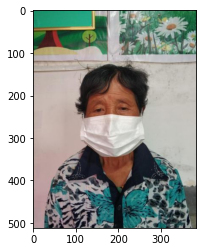

In [63]:

# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]

idx = 50
image = cv2.imread(image_paths[idx])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

image = tfms_test(image=image)['image'].to(device)
image = image.unsqueeze(0)
pred = model(image)
print(pred)
label = np.argmax(pred.detach().cpu().numpy())
#
masklabel = {0: "Mask", 1: "Incorrect", 2: "Normal"}
genderlabel = {0: "Male", 1: "Female"}
agelabel = {0: "~ 30", 1: "30 ~ 60", 2: "60 ~"}

feature_to_label = {}
features = [(m, g, a) for m in ['Mask', 'Incorrect', 'Normal'] for g in ['Male', 'Female'] for a in ["~ 30", "30 ~ 60", "60 ~"]]
for i, (m, g, a) in enumerate(features):
    feature_to_label[(m, g, a)] = i
#
label_to_feature = { feature_to_label[k]:k for k in feature_to_label}
m, g, a = label_to_feature[label]
print(m)
print(g)
print(a)
